https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q rouge-score
!pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 14.9 MB/s 
     |████████████████████████████████| 5.8 MB 3.1 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 5.9 MB 58.0 MB/s 
     |████████████████████████████████| 578.1 MB 8.1 kB/s 
     |████████████████████████████████| 578.1 MB 7.1 kB/s 
     |████████████████████████████████| 4.6 MB 76.9 MB/s 


In [1]:
import keras_nlp
import numpy as np
import pandas as pd
import pathlib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import  model_from_json
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [13]:
BATCH_SIZE = 32
EPOCHS = 1  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 20
ENG_VOCAB_SIZE = 104890
SND_VOCAB_SIZE = 104890

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [4]:
data = pd.read_csv('english-sindhi2.csv')

In [5]:
data

,English,Sindhi
0,the,جي
1,of,جو
2,to,جي طرف
3,and,۽
4,a,هڪ
...,...,...
104885,a carbon footprint is the amount of carbon dio...,ڪاربان فوٽ پرنٽ ڪاربان ڊاء آڪسائيڊ آلودگي جي م...
104886,death is something that were often discouraged...,موت هڪ اهڙي شيء آهي جنهن جي باري ڳالهائڻ يا ا...
104887,since there are usually multiple websites on a...,جيئن ته عام طور تي ڪنهن به موضوع تي ڪيتريون ئي...
104888,if someone who doesnt know your background say...,جيڪڏهن ڪو ماڻهو جيڪو توهان جي پس منظر کان واقف...


In [6]:
text_pairs = data.values.tolist()

In [7]:
for _ in range(5):
  print(random.choice(text_pairs))

['ok thats enough', 'ٺيڪ اهو ڪافي آهي']
['this doesnt look good at all', 'اهو سڀ ڪجهه سٺو نٿو لڳي']
['this pizza is really good', 'هي پيزا واقعي سٺو آهي']
['the government has imposed a new tax on wine', 'حڪومت شراب تي نئون ٽيڪس لاڳو ڪري ڇڏيو آهي']
['i had to get some help', 'مون کي ڪجهه مدد وٺڻي هئي']


In [8]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

104890 total pairs
73424 training pairs
15733 validation pairs
15733 test pairs


In [9]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    bert_vocab_args = dict(
        # The target vocabulary size
        vocab_size=vocab_size,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `text.BertTokenizer`
        bert_tokenizer_params={"lower_case": True},
    )

    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = bert_vocab.bert_vocab_from_dataset(
        word_piece_ds.batch(1000).prefetch(2), **bert_vocab_args
    )
    return vocab

In [11]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    bert_vocab_args = dict(
        # The target vocabulary size
        vocab_size=vocab_size,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `text.BertTokenizer`
        bert_tokenizer_params={"lower_case": True},
    )

    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = bert_vocab.bert_vocab_from_dataset(
        word_piece_ds.batch(1000).prefetch(2), **bert_vocab_args
    )
    return vocab

In [14]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

snd_samples = [text_pair[1] for text_pair in train_pairs]
snd_vocab = train_word_piece(snd_samples, SND_VOCAB_SIZE, reserved_tokens)

In [15]:
print("English Tokens: ", eng_vocab[100:110])
print("Sindhi Tokens: ", snd_vocab[100:110])

English Tokens:  ['up', 'out', 'if', 'an', 'didnt', 'going', 'just', 'one', 'would', 'from']
Sindhi Tokens:  ['۽', '۾', 'اهي', 'کي', 'مون', 'مان', 'توهان', 'جي', 'ته', 'نه']


In [16]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
snd_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=snd_vocab, lowercase=False
)

In [17]:
eng_input_ex = text_pairs[0][0]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print("Recovered text after detokenizing: ", eng_tokenizer.detokenize(eng_tokens_ex))

print()

snd_input_ex = text_pairs[0][1]
snd_tokens_ex = snd_tokenizer.tokenize(snd_input_ex)
print("Sindhi sentence: ", snd_input_ex)
print("Tokens: ", snd_tokens_ex)
print("Recovered text after detokenizing: ", snd_tokenizer.detokenize(snd_tokens_ex))

English sentence:  id love to be able to spend less time doing household chores
Tokens:  tf.Tensor(
[ 153  175   43   67  371   43  553  887   88  213  176  719 2424   17
  719 1280   62], shape=(17,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'id love to be able to spend less time doing household chores', shape=(), dtype=string)

Sindhi sentence:  مان گھريلو ڪم ڪرڻ  گھٽ وقت گذارڻ جي قابل ٿي ويندس
Tokens:  tf.Tensor([ 105  673  962  207  151  125 1662  145  994  107  440  127  425], shape=(13,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'\xd9\x85\xd8\xa7\xd9\x86 \xda\xaf\xda\xbe\xd8\xb1\xd9\x8a\xd9\x84\xd9\x88 \xda\xaa\xd9\x85 \xda\xaa\xd8\xb1\xda\xbb \xda\xaf\xda\xbe\xd9\xbd \xd9\x88\xd9\x82\xd8\xaa \xda\xaf\xd8\xb0\xd8\xa7\xd8\xb1\xda\xbb \xd8\xac\xd9\x8a \xd9\x82\xd8\xa7\xd8\xa8\xd9\x84 \xd9\xbf\xd9\x8a \xd9\x88\xd9\x8a\xd9\x86\xd8\xaf\xd8\xb3', shape=(), dtype=string)


In [20]:
def preprocess_batch(eng, snd):
    batch_size = tf.shape(snd)[0]

    eng = eng_tokenizer(eng)
    snd = snd_tokenizer(snd)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `snd` and pad it as well.
    snd_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=snd_tokenizer.token_to_id("[START]"),
        end_value=snd_tokenizer.token_to_id("[END]"),
        pad_value=snd_tokenizer.token_to_id("[PAD]"),
    )
    snd = snd_start_end_packer(snd)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": snd[:, :-1],
        },
        snd[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, snd_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    snd_texts = list(snd_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, snd_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

TypeError: in user code:

    File "C:\Users\Rimsha\AppData\Local\Temp\ipykernel_2872\1247225654.py", line 12, in preprocess_batch  *
        eng = eng_start_end_packer(eng)
    File "c:\Users\Rimsha\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "start_end_packer" (type StartEndPacker).
    
    in user code:
    
        File "c:\Users\Rimsha\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_nlp\layers\start_end_packer.py", line 122, in call  *
            batch_size = tf.shape(inputs)[0]
    
        TypeError: Failed to convert elements of tf.RaggedTensor(values=Tensor("word_piece_tokenizer/FastWordpieceTokenizeWithOffsets/FastWordpieceTokenizeWithOffsets/Cast:0", shape=(None,), dtype=int32), row_splits=Tensor("word_piece_tokenizer/RaggedFromRowSplits_3/control_dependency:0", shape=(None,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
    
    
    Call arguments received:
      • inputs=tf.RaggedTensor(values=Tensor("word_piece_tokenizer/FastWordpieceTokenizeWithOffsets/FastWordpieceTokenizeWithOffsets/Cast:0", shape=(None,), dtype=int32), row_splits=Tensor("word_piece_tokenizer/RaggedFromRowSplits_3/control_dependency:0", shape=(None,), dtype=int64))


In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=SND_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(SND_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

In [ ]:
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
hist = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 256)   26856960    ['encoder_inputs[0][0]']         
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1315072     ['token_and_position_em

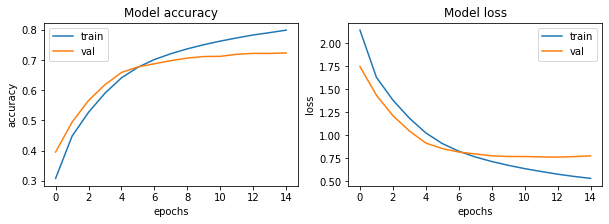

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
def decode_sequences(input_sentences):
  batch_size = tf.shape(input_sentences)[0]

  # Tokenize the encoder input.
  encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
    shape=(None, MAX_SEQUENCE_LENGTH)
  )

  # Define a function that outputs the next token's probability given the
  # input sequence.
  def token_probability_fn(decoder_input_tokens):
    return transformer([encoder_input_tokens, decoder_input_tokens])[:, -1, :]

  # Set the prompt to the "[START]" token.
  prompt = tf.fill((batch_size, 1), snd_tokenizer.token_to_id("[START]"))

  generated_tokens = keras_nlp.utils.greedy_search(
    token_probability_fn,
    prompt,
    max_length=20,
    end_token_id=snd_tokenizer.token_to_id("[END]"),
  )
  generated_sentences = snd_tokenizer.detokenize(generated_tokens)
  return generated_sentences


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(2):
  input_sentence = random.choice(test_eng_texts)
  translated = decode_sequences(tf.constant([input_sentence]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  print(f"** Example {i} **")
  print(input_sentence)
  print(translated)
  print()

** Example 0 **
i nailed it
مان ان کي نيلو اهيان

** Example 1 **
i had some problems to take care of
مون وٽ خيال رکڻ لاء ڪجهه مسيلا هيا



In [ ]:
rouge_1 = keras_nlp.metrics.RougeN(order=1)
rouge_2 = keras_nlp.metrics.RougeN(order=2)

for test_pair in test_pairs[:30]:
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1]

    translated_sentence = decode_sequences(tf.constant([input_sentence]))
    translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
    translated_sentence = (
        translated_sentence.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    rouge_1(reference_sentence, translated_sentence)
    rouge_2(reference_sentence, translated_sentence)

print("ROUGE-1 Score: ", rouge_1.result())
print("ROUGE-2 Score: ", rouge_2.result())

In [ ]:
# serialize model to JSON
model_json = transformer.to_json()
with open("/content/drive/MyDrive/model_KerasNLP.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
transformer.save_weights("/content/drive/MyDrive/model_KerasNLP.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/model_KerasNLP.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'TokenAndPositionEmbedding': keras_nlp.layers.TokenAndPositionEmbedding,
                                                                  'TransformerEncoder': keras_nlp.layers.TransformerEncoder,
                                                                  'TransformerDecoder': keras_nlp.layers.TransformerDecoder})
# load weights into new model
model.load_weights("/content/drive/MyDrive/model_KerasNLP.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def decode_sequences(input_sentences):
  batch_size = tf.shape(input_sentences)[0]

  # Tokenize the encoder input.
  encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
    shape=(None, MAX_SEQUENCE_LENGTH)
  )

  # Define a function that outputs the next token's probability given the
  # input sequence.
  def token_probability_fn(decoder_input_tokens):
    return model([encoder_input_tokens, decoder_input_tokens])[:, -1, :]

  # Set the prompt to the "[START]" token.
  prompt = tf.fill((batch_size, 1), snd_tokenizer.token_to_id("[START]"))

  generated_tokens = keras_nlp.utils.greedy_search(
    token_probability_fn,
    prompt,
    max_length=20,
    end_token_id=snd_tokenizer.token_to_id("[END]"),
  )
  generated_sentences = snd_tokenizer.detokenize(generated_tokens)
  return generated_sentences


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(2):
  input_sentence = random.choice(test_eng_texts)
  translated = decode_sequences(tf.constant([input_sentence]))
  translated = translated.numpy()[0].decode("utf-8")
  translated = (
      translated.replace("[PAD]", "")
      .replace("[START]", "")
      .replace("[END]", "")
      .strip()
  )
  print(f"** Example {i} **")
  print(input_sentence)
  print(translated)
  print()

** Example 0 **
you understand me
تون مون کي سمجهين ٿو

** Example 1 **
because of the rain we werent able to play tennis outside
برسات جي ڪري اسان ٽينس کيڏڻ جي قابل نه هياسين



In [ ]:
translated = decode_sequences(tf.constant(['this is dog']))
translated = translated.numpy()[0].decode("utf-8")
translated = (
    translated.replace("[PAD]", "")
    .replace("[START]", "")
    .replace("[END]", "")
    .strip())

In [ ]:
print(translated)

هي ڪتو اهي


In [ ]:
print('end')